### Import libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
# from absl import flags
import tensorflow as tf
import tensorflow_privacy
from keras.models import Model
import matplotlib.pyplot as plt
from skimage.feature import hog
from PIL import Image, ImageOps
import tensorflow_addons as tfa
from keras.models import Sequential
# from livelossplot import PlotLossesKeras
from keras.applications.vgg16 import VGG16
from keras.layers.convolutional import Conv2D
from tensorflow.keras.datasets import cifar10
from tensorflow_addons.layers import GroupNormalization
from keras.layers import Input, Dense, Flatten, Dropout, Add, LayerNormalization
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent
from keras.layers.pooling import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
tf.compat.v1.disable_v2_behavior()
tf.get_logger().setLevel('ERROR')
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


### Load Dataset

In [2]:
def hog_transform(train):
    train_hog = []
    for sample in train:
        img = Image.fromarray(np.uint8(sample)).convert('RGB')
        img = ImageOps.grayscale(img)
        hog_features = hog(img, orientations = 9, pixels_per_cell = (2, 2), 
                           cells_per_block = (1, 1), block_norm = 'L2', visualize = False)
        train_hog.append(hog_features)
    train_hog = np.array(train_hog)
    return train_hog

In [3]:
# Loading cifar10 image dataset
data_train, data_test = cifar10.load_data()
x_train, y_train = data_train
x_test, y_test = data_test

# Hog transformations of images
x_train_hog = hog_transform(x_train)
x_test_hog = hog_transform(x_test)

# Normalizing pixel values of images
x_train = x_train / 255.0
x_test = x_test / 255.0

# Flattening images in dataset
y_train = y_train.flatten().reshape(y_train.shape[0], 1)
y_test = y_test.flatten().reshape(y_test.shape[0], 1)

# One hot encoding of labels/target column
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print("training:", x_train.shape, y_train.shape)
print("testing:", x_test.shape, y_test.shape)
print("--------------------------------")
print("hog training:", x_train_hog.shape, y_train.shape)
print("hog testing:", x_test_hog.shape, y_test.shape)

training: (50000, 32, 32, 3) (50000, 10)
testing: (10000, 32, 32, 3) (10000, 10)
--------------------------------
hog training: (50000, 2304) (50000, 10)
hog testing: (10000, 2304) (10000, 10)


### Model Architectures

In [8]:
#### VGG with transfer learning
def pre_trained_vgg():
    #Building a VGG model with pretrained weights from cifar100
    model = Sequential()
    vgg_model = VGG16(include_top=False, weights="imagenet",
                      classes=10, pooling=max, input_shape=(32,32,3))
    vgg_model.trainable=False
    model.add(vgg_model)
    model.add(Flatten())
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(16, activation='tanh'))
    model.add(Dense(10, activation='softmax'))
    return model


#### HOG + ANN
def hog_ann():
    ### Feed-forward network
    model_input = Input(shape = (2304))
    d1 = Dense(8, activation = 'tanh')(model_input)
    d1 = Dropout(0.1)(d1)
    d2 = Dense(16, activation = 'tanh')(d1)
    d2 = LayerNormalization()(d2)
    d3 = Dense(16, activation = 'tanh')(d2)
    d3 = Dropout(0.1)(d3)
    d4 = Dense(8, activation = 'tanh')(d3)
    d4 = LayerNormalization()(d4)
    d5 = Dense(8, activation = 'tanh')(d4)
    model_output = Dense(10, activation = 'softmax')(d5)
    model = Model(inputs = model_input, outputs = model_output)
    return model


#### Custom CNN
def cnn():
    ## CNN network
    model_input = Input(shape = (32, 32, 3))
    x1 = Conv2D(16, (8, 8), activation = 'tanh', strides = 2)(model_input)
    x1 = LayerNormalization()(x1)
    x1 = Dropout(0.4)(x1)
    x1 = MaxPooling2D(pool_size = (2,1))(x1)
    x2 = Conv2D(32, (4, 4), activation = 'tanh', strides = 2)(x1)
    x2 = MaxPooling2D(pool_size = (2,1))(x2)
    x2 = LayerNormalization()(x2)
    ftn = Flatten()(x2)
    ### Feed-forward network
    d1 = Dense(8, activation = 'tanh')(ftn)
    d1 = Dropout(0.1)(d1)
    d2 = Dense(16, activation = 'tanh')(d1)
    d2 = LayerNormalization()(d2)
    d3 = Dropout(0.1)(d3)
    d4 = Dense(8, activation = 'tanh')(d3)
    d4 = LayerNormalization()(d4)
    d5 = Dense(8, activation = 'tanh')(d4)
    model_output = Dense(10, activation = 'softmax')(d5)
    model = Model(inputs = model_input, outputs = model_output)
    return model


#### ResNet-10
def resnet():
    ### Custom ResNet model
    model_input = Input(shape = (32, 32, 3))
    x1 = Conv2D(8, (3, 3), activation = 'tanh', strides = 2)(model_input)
#     x2 = Conv2D(32, (3, 3), activation = 'tanh', strides = 2)(x1)
    x2 = MaxPooling2D(pool_size = (3,3))(x1)
    ## Residual Block 1
    x3 = Conv2D(8, (3, 3), activation = 'relu', strides = 1)(x2)
    x3 = LayerNormalization()(x3) # normalization layer 1
    x4 = Conv2D(8, (3, 3), activation = 'relu', strides = 1)(x3)
    sk1 = Add()([x2, x4]) # skip connection 1
    ## Residual Block 2
    x5 = Conv2D(8, (3, 3), activation = 'relu', strides = 1)(sk1)
    x5 = LayerNormalization()(x5) # normalization layer 2
    x6 = Conv2D(8, (3, 3), activation = 'relu', strides = 1)(x5)
    sk2 = Add()([sk1, x6]) # skip connection 2
#     ## Residual Block 3
#     x7 = Conv2D(64, (3, 3), activation = 'relu', strides = 1)(sk2)
#     x7 = LayerNormalization()(x7) # normalization layer 3
#     x8 = Conv2D(64, (3, 3), activation = 'relu', strides = 1)(x7)
#     sk3 = Add()([sk2, x8]) # skip connection 3
#     ## Residual Block 4
#     x9 = Conv2D(64, (3, 3), activation = 'relu', strides = 1)(sk3)
#     x9 = LayerNormalization()(x9) # normalization layer 4
#     x10 = Conv2D(64, (3, 3), activation = 'relu', strides = 1)(x9)
#     sk4 = Add()([sk3, x10]) # skip connection 4
    ## Global Average Pooling layer
    avg = GlobalAveragePooling2D()(sk2)
    ftn = Flatten()(avg)
    # Feed-forward network
    d1 = Dense(16, activation = 'tanh')(ftn)
    d2 = Dense(16, activation = 'tanh')(d1)
    model_output = Dense(10, activation = 'softmax')(d2)
    model = Model(inputs = model_input, outputs = model_output)
    return model


#### VGG-8
def vgg():
    ### Custom VGG model
    model_input = Input(shape = (32, 32, 3))
    x1 = Conv2D(8, (3, 3), activation = 'tanh', strides = 1)(model_input)
#     x2 = Conv2D(64, (3, 3), activation = 'tanh', strides = 1)(x1)
    x2 = MaxPooling2D(pool_size = (3,3), strides = 2)(x1)
    x3 = Conv2D(16, (3, 3), activation = 'tanh', strides = 1)(x2)
    x4 = Conv2D(32, (3, 3), activation = 'tanh', strides = 1)(x3)
    x4 = MaxPooling2D(pool_size = (3,3), strides = 2)(x4)
#     x5 = Conv2D(32, (3, 3), activation = 'tanh', strides = 1)(x4)
#     x6 = Conv2D(32, (3, 3), activation = 'relu', strides = 1)(x5)
#     x7 = Conv2D(32, (3, 3), activation = 'relu', strides = 1)(x6)
    x7 = MaxPooling2D(pool_size = (3,3), strides = 2)(x4)
    ftn = Flatten()(x7)
    # Feed-forward network
    d1 = Dense(8, activation = 'tanh')(ftn)
    d1 = Dropout(0.4)(d1)
    d2 = Dense(16, activation = 'tanh')(d1)
    d2 = Dropout(0.4)(d2)
    model_output = Dense(10, activation = 'softmax')(d2)
    model = Model(inputs = model_input, outputs = model_output)
    return model

### Privacy Hyper-parameters

In [12]:
epochs = 100
batch_size = 2000
l2_norm_clip = 0.75
noise_multiplier = 2.06
num_microbatches = 100
learning_rate = 0.085
delta = 1e-5

if batch_size % num_microbatches != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')
    
# Compute RDP
orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
rdp = compute_rdp(q = batch_size / 50000,
                  noise_multiplier = noise_multiplier,
                  steps = epochs * 50000 // batch_size,
                  orders = orders)
# Calculate epsilon
epsilon = get_privacy_spent(orders, rdp, target_delta = delta)[0]
epsilon

4.998994314017812

### Optimizer and Loss function

In [13]:
# define optimizer (dp-sgd) 
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

# # define optimizer (dp-adam)
# optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
#     l2_norm_clip=l2_norm_clip,
#     noise_multiplier=noise_multiplier,
#     num_microbatches=num_microbatches,
#     learning_rate=learning_rate,
#     gradient_accumulation_steps=5)

# define loss function
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)

### Compile and train model

In [14]:
model_hog = False
## Model
# model = pre_trained_vgg()
# model_hog = hog_ann()
model = resnet()
# model = vgg()

## HOG_training
if model_hog:
    x_train = x_train_hog
    x_test = x_test_hog 
    model = model_hog
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_14 (Conv2D)             (None, 15, 15, 8)    224         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 5, 5, 8)     0           ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_15 (Conv2D)             (None, 3, 3, 8)      584         ['max_pooling2d_2[0][0]']        
                                                                                            

In [15]:
## Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
## Train model
history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test),
          batch_size=batch_size, verbose = 1)

Train on 50000 samples, validate on 10000 samples


2022-03-27 16:27:22.934275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-27 16:27:23.727459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/100


2022-03-27 16:27:24.065264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-27 16:27:24.269708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50000/50000 [==============================] - ETA: 0s - loss: 2.3352 - acc: 0.1211 

2022-03-27 16:32:54.388676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50000/50000 [==============================] - 331s 7ms/sample - loss: 2.3352 - acc: 0.1211 - val_loss: 2.2814 - val_acc: 0.1366
Epoch 2/100
50000/50000 [==============================] - 246s 5ms/sample - loss: 2.2437 - acc: 0.1582 - val_loss: 2.2005 - val_acc: 0.1784
Epoch 3/100
50000/50000 [==============================] - 268s 5ms/sample - loss: 2.1899 - acc: 0.1778 - val_loss: 2.1769 - val_acc: 0.1702
Epoch 4/100
50000/50000 [==============================] - 267s 5ms/sample - loss: 2.1565 - acc: 0.1836 - val_loss: 2.1176 - val_acc: 0.1925
Epoch 5/100
50000/50000 [==============================] - 273s 5ms/sample - loss: 2.1207 - acc: 0.1934 - val_loss: 2.1078 - val_acc: 0.1939
Epoch 6/100
50000/50000 [==============================] - 273s 5ms/sample - loss: 2.0956 - acc: 0.1992 - val_loss: 2.1066 - val_acc: 0.1869
Epoch 7/100
50000/50000 [==============================] - 270s 5ms/sample - loss: 2.0735 - acc: 0.2065 - val_loss: 2.0765 - val_acc: 0.2083
Epoch 8/100
50000/50000 [

Epoch 59/100
50000/50000 [==============================] - 188s 4ms/sample - loss: 1.7878 - acc: 0.3185 - val_loss: 1.7966 - val_acc: 0.3239
Epoch 60/100
50000/50000 [==============================] - 190s 4ms/sample - loss: 1.7770 - acc: 0.3219 - val_loss: 1.7711 - val_acc: 0.3260
Epoch 61/100
50000/50000 [==============================] - 189s 4ms/sample - loss: 1.7889 - acc: 0.3199 - val_loss: 1.7754 - val_acc: 0.3264
Epoch 62/100
50000/50000 [==============================] - 188s 4ms/sample - loss: 1.7687 - acc: 0.3238 - val_loss: 1.7551 - val_acc: 0.3284
Epoch 63/100
50000/50000 [==============================] - 189s 4ms/sample - loss: 1.7719 - acc: 0.3227 - val_loss: 1.7812 - val_acc: 0.3223
Epoch 64/100
50000/50000 [==============================] - 190s 4ms/sample - loss: 1.7570 - acc: 0.3257 - val_loss: 1.7411 - val_acc: 0.3327
Epoch 65/100
50000/50000 [==============================] - 191s 4ms/sample - loss: 1.7620 - acc: 0.3257 - val_loss: 1.7579 - val_acc: 0.3305
Epoch 

train_acc: 0.348      train_loss: 1.802
val_acc: 0.357        val_loss: 1.262


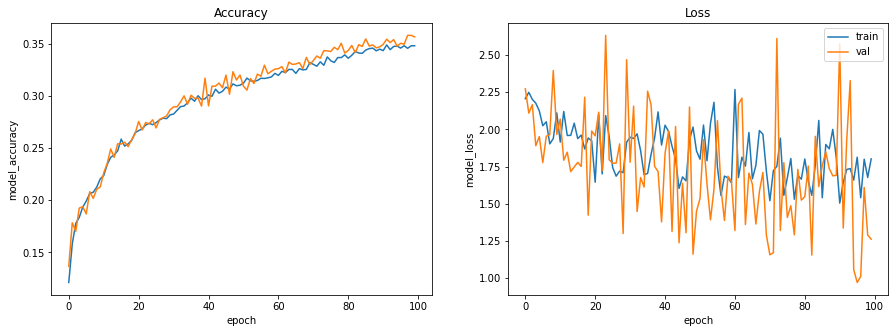

In [16]:
### Plotting accuracy/loss graph
def get_loss(history_loss):
    loss = []
    for epoch in history_loss:
        loss.append(epoch[-1])
    return loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = get_loss(history.history['loss'])
val_loss = get_loss(history.history['val_loss'])
print('train_acc:', round(acc[-1], 3), "    ", 'train_loss:', round(loss[-1], 3))
print('val_acc:', round(val_acc[-1], 3), "      ", 'val_loss:', round(val_loss[-1], 3))
fig = plt.figure(figsize=(15, 5))
## Accuracy plot
plt.subplot(1, 2, 1) 
plt.plot(acc)
plt.plot(val_acc)
plt.title('Accuracy')
plt.ylabel('model_accuracy')
plt.xlabel('epoch')
## Loss plot
plt.subplot(1, 2, 2) 
plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('model_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()